In [ ]:
# Inspired by quantum ML code from:
# https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html
# And classical ML code from:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Adversarial Code adapted from:
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# Some code/data also adapted from HW5
# This was run in GCP w/ a high-powered GPU

In [ ]:
# Data set up
# NOTE this was not run again since data was already downloaded from HW5
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"ajcsatx","key":"8422e417829c4302e519401276daaf1a"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
!rm -r test1.zip sampleSubmission.csv dogs-vs-cats.zip
!mkdir ./data
!mkdir ./data/dogs-vs-cats
!unzip train.zip -d ./data/dogs-vs-cats
!mkdir ./data/dogs-vs-cats/train/cat
!mkdir ./data/dogs-vs-cats/train/dog
# Only keep first 10000 images of each class to end up w/ 20000 total
import os
for i in range(10000):
    os.rename(f'./data/dogs-vs-cats/train/cat.{i}.jpg',
              f'./data/dogs-vs-cats/train/cat/{i}.jpg')
    os.rename(f'./data/dogs-vs-cats/train/dog.{i}.jpg',
              f'./data/dogs-vs-cats/train/dog/{i}.jpg')

In [2]:
import os
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
import torch.nn.functional as F

# Pennylane Imports (this is the Quantum stuff!)
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(7)
np.random.seed(7)
os.environ["OMP_NUM_THREADS"] = "1"

In [15]:
# Load in pretrained ResNet-18 model weights from PyTorch
resnet18 = models.resnet18(pretrained=True)
model_hybrid = models.resnet18(pretrained=True)

/home/as6734/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/as6734/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Hybrid Classical/Quantum Model

In [3]:
# Set params for quantum circuit and training params
# Num qubits, chosen as 4 to be significant, but not
# too large for efficient training
qubit_count = 4
step = 0.0004  # Initial learning rate
batch_size = 50
num_epochs = 10
circ_repeats = 6  # How many times to repeat RY and CNOT gates
gamma_lr_scheduler = 0.1  # Learning rate decay param
q_delta = 0.01  # Param for quantum circuit weight initialization

# Run quantum circuit on Pennylane default simulator
dev = qml.device('default.qubit', wires=qubit_count)

# If GPU available, set to run on it
# If GPU available, set to run on it
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Import the data using Pytorch ImageFolder, then randomly split into
# train, validation, and test datasets
# This is the same data from HW5
# (to see how that was downloaded, see that assignment file or above)
data_folder = '../hw5/data/dogs-vs-cats/train'
all_data = datasets.ImageFolder(data_folder, 
                                transform=transforms.Compose(
                                    [transforms.ToTensor(), 
                                     transforms.Resize(size=[224, 224])]))
# Note that while random split does not guarantee class balance, on the order of
# thousands it is approximately even
train_set, valid_set, test_set = torch.utils.data.random_split(
    all_data,
    [16000, 2000, 2000],
    generator=torch.Generator().manual_seed(7))

In [5]:
# Capture data sizes, classes, and create dataloaders
dataset_sizes = {'train': 16000, 'validation': 2000, 'test': 2000}
class_names = all_data.classes
dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'validation': torch.utils.data.DataLoader(valid_set, batch_size=batch_size),
    'test': torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=1)
}

In [6]:
# Helper functions to construct quantum circuit
def ry_gates(w):
    # Apply rotation gate RY w/ given weights
    for i, weight in enumerate(w):
        qml.RY(weight, wires=i)

# Adds alternating CNOT layer to entangle qubits
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  # Evens
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Odds
        qml.CNOT(wires=[i, i + 1])

In [7]:
# Function to construct quantum circuit to plug into PyTorch
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, q_weights_flat):
    # Reshape weights
    q_weights = q_weights_flat.reshape(circ_repeats, qubit_count)
    # Initialize w/ H gates so orthogonal to computational basis
    # This helps start w/out bias towards 0 or 1 states
    for i in range(qubit_count):
        qml.Hadamard(wires=i)
    # Take given inputs and apply to quantum circuit as first weights
    ry_gates(inputs)
    # Repeat CNOT and RY gates to add more weights to train and
    # CNOT "convolutions" (really entangles)
    for k in range(circ_repeats):
        entangling_layer(qubit_count)
        ry_gates(q_weights[k])
    # Use Pennylane sim to get expected value after applying Z gate
    # which returns to standard computational basis, this is layer output
    expected_vals = [qml.expval(qml.PauliZ(entry)) for entry in range(qubit_count)]
    return tuple(expected_vals)

In [8]:
# Extend PyTorch Module class to describe the replacement layer
# for ResNet-18's final fc layer
class HybridQuantumNet(nn.Module):
    # Initialize layers
    def __init__(self):
        super().__init__()
        self.pre_quant = nn.Linear(512, qubit_count)
        self.q_params = nn.Parameter(q_delta * torch.randn(circ_repeats * qubit_count))
        self.post_quant = nn.Linear(qubit_count, 2)

    # Forward pass procedure
    def forward(self, input_features):
        # Map 512 output to qubit_count output
        pre_out = self.pre_quant(input_features)
        # Convert to radians for use as RY rotation gate params
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        # Apply quantum circuit to each batch image, set to run on GPU
        q_out = torch.Tensor(0, qubit_count)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_circuit(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        # Map quantum circuit output using linear layer to classes
        return self.post_quant(q_out)

In [16]:
# Freeze weights for pre-trained model
for param in model_hybrid.parameters():
    param.requires_grad = False
# Replace final fully connected layer of ResNet-18 with quantum net
model_hybrid.fc = HybridQuantumNet()
# Make sure set to use GPU
model_hybrid = model_hybrid.to(device)

In [10]:
# Set up loss, optimizer, and learning rate decay manager
loss_func = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [ ]:
# Function to train model(s)
def train(model, loss_func, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 100000.0
    best_acc_train = 0.0
    best_loss_train = 100000.0
    print('Training started:')
    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'validation']:
            if phase == 'train':
                # Set model to train mode
                model.train()
            else:
                # Set model to eval mode
                model.eval()
            current_loss = 0.0
            current_corrects = 0
            n_batches = dataset_sizes[phase] // batch_size
            iter = 0
            for X, Y in dataloaders[phase]:
                batch_len = len(X)
                X = X.to(device)
                X = X.to(device)
                optimizer.zero_grad()  # Reset gradients
                # If in train mode, get loss, step optimizer
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(X)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_func(outputs, Y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # Print iteration results
                current_loss += loss.item() * batch_len
                batch_corrects = torch.sum(preds == X.data).item()
                current_corrects += batch_corrects
                print('Phase: {} Epoch: {}/{} Iter: {}/{}'.format(phase, epoch+1, num_epochs, iter+1, n_batches+1),
                    end="\r",
                    flush=True)
                iter += 1

            # Get epoch stats and print
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects / dataset_sizes[phase]
            print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format(
                    'train' if phase == 'train' else 'validation  ',
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )
            # Update best var

In [9]:
s and make copy of best weights
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
            # Decay learning rate
            if phase == "train":
                scheduler.step()
    # Print final results
    model.load_state_dict(best_model_wts)
    print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
    return model

In [12]:
model_hybrid = train(model_hybrid, loss_func, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:


  0%|                                                                                   | 0/10 [00:00<?, ?it/s]

Phase: train Epoch: 1/10 Loss: 0.2376 Acc: 0.9451        


 10%|███████▏                                                                | 1/10 [16:00<2:24:00, 960.09s/it]

Phase: validation   Epoch: 1/10 Loss: 0.1454 Acc: 0.9615        
Phase: train Epoch: 2/10 Loss: 0.1238 Acc: 0.9679        


 20%|██████████████▍                                                         | 2/10 [31:07<2:03:51, 929.00s/it]

Phase: validation   Epoch: 2/10 Loss: 0.1046 Acc: 0.9690        
Phase: train Epoch: 3/10 Loss: 0.1018 Acc: 0.9675        


 30%|█████████████████████▌                                                  | 3/10 [46:04<1:46:42, 914.67s/it]

Phase: validation   Epoch: 3/10 Loss: 0.0852 Acc: 0.9760        
Phase: train Epoch: 4/10 Loss: 0.0790 Acc: 0.9745        


 40%|████████████████████████████                                          | 4/10 [1:00:59<1:30:39, 906.66s/it]

Phase: validation   Epoch: 4/10 Loss: 0.0788 Acc: 0.9750        
Phase: train Epoch: 5/10 Loss: 0.0788 Acc: 0.9727        


 50%|███████████████████████████████████                                   | 5/10 [1:15:54<1:15:12, 902.46s/it]

Phase: validation   Epoch: 5/10 Loss: 0.0737 Acc: 0.9755        
Phase: train Epoch: 6/10 Loss: 0.0723 Acc: 0.9735        


 60%|███████████████████████████████████████████▏                            | 6/10 [1:30:47<59:57, 899.36s/it]

Phase: validation   Epoch: 6/10 Loss: 0.0694 Acc: 0.9785        
Phase: train Epoch: 7/10 Loss: 0.0644 Acc: 0.9762        


 70%|██████████████████████████████████████████████████▍                     | 7/10 [1:45:42<44:53, 897.88s/it]

Phase: validation   Epoch: 7/10 Loss: 0.0791 Acc: 0.9730        
Phase: train Epoch: 8/10 Loss: 0.0636 Acc: 0.9772        


 80%|█████████████████████████████████████████████████████████▌              | 8/10 [2:00:42<29:57, 898.58s/it]

Phase: validation   Epoch: 8/10 Loss: 0.0630 Acc: 0.9790        
Phase: train Epoch: 9/10 Loss: 0.0659 Acc: 0.9747        


 90%|████████████████████████████████████████████████████████████████▊       | 9/10 [2:15:40<14:58, 898.39s/it]

Phase: validation   Epoch: 9/10 Loss: 0.0653 Acc: 0.9795        
Phase: train Epoch: 10/10 Loss: 0.0647 Acc: 0.9749        


100%|███████████████████████████████████████████████████████████████████████| 10/10 [2:30:39<00:00, 903.96s/it]

Phase: validation   Epoch: 10/10 Loss: 0.0591 Acc: 0.9825        
Best test loss: 0.0591 | Best test accuracy: 0.9825


In [13]:
# Save model weights locally in case of GCP crash
torch.save(model_hybrid.state_dict(), './weights/hybrid_10epochs.pt')

In [17]:
# Load in saved weights, put in model, and than set to eval mode
best_weights = torch.load('./weights/hybrid_10epochs.pt')
model_hybrid.load_state_dict(best_weights)
model_hybrid.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
# Example visualization codes with nonsense weights
# Helps to see what the quantum circuit looks like
q_params_print = nn.Parameter(q_delta * torch.randn(circ_repeats * qubit_count))
input_test = torch.randn(1,512)
pre_net_test = nn.Linear(512, qubit_count)
pre_out_test = pre_net_test(input_test)
q_in_test = torch.tanh(pre_out_test) * np.pi / 2.0
for elem in q_in_test:
    print(qml.draw(quantum_circuit)(elem, q_params_print))

0: ──H──RY(0.12)──╭●──RY(-0.00)───────────╭●──RY(-0.01)────────────╭●──RY(-0.02)────────────╭●
1: ──H──RY(-0.07)─╰X─╭●──────────RY(0.00)─╰X─╭●──────────RY(0.00)──╰X─╭●──────────RY(-0.01)─╰X
2: ──H──RY(-0.72)─╭●─╰X──────────RY(0.00)─╭●─╰X──────────RY(-0.00)─╭●─╰X──────────RY(0.01)──╭●
3: ──H──RY(0.65)──╰X──RY(-0.01)───────────╰X──RY(-0.00)────────────╰X──RY(0.01)─────────────╰X

───RY(-0.00)────────────╭●──RY(0.02)────────────╭●──RY(0.00)────────────┤  <Z>
──╭●──────────RY(-0.02)─╰X─╭●─────────RY(0.00)──╰X─╭●──────────RY(0.02)─┤  <Z>
──╰X──────────RY(-0.01)─╭●─╰X─────────RY(-0.00)─╭●─╰X──────────RY(0.01)─┤  <Z>
───RY(0.00)─────────────╰X──RY(0.02)────────────╰X──RY(-0.01)───────────┤  <Z>


In [21]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Get gradient signs
    sign_data_grad = data_grad.sign()
    # Add to each pixel the sign * epsilon
    perturbed_image = image + epsilon*sign_data_grad
    # Make sure to stay in [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [22]:
# Tests model (if epsilon=0, standard test set images)
# Otherwise perturbs using FGSM attack
# Also stores example images where the perturbation caused a mislabel
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in tqdm(test_loader):
        # Send the data and label to GPU
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # Don't care to attack if already wrong
        if init_pred.item() != target.item():
            continue
        # Get loss backprop for gradient values
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        # Collect gradients
        data_grad = data.grad.data
        # Call FGSM function
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    # Get accuracy metric
    final_acc = correct / float(dataset_sizes['test'])
    print('Epsilon: {}\tTest Accuracy = {} / {} = {}'.format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [24]:
epsilons = [0.0, 0.01, 0.05, 0.1, 0.2]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_hybrid, device, dataloaders['test'], eps)
    accuracies.append(acc)
    examples.append(ex)

100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:10<00:00, 10.53it/s]


Epsilon: 0	Test Accuracy = 1957 / 2000 = 0.9785


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:10<00:00, 10.52it/s]


Epsilon: 0	Test Accuracy = 1957 / 2000 = 0.9785


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:09<00:00, 10.57it/s]


Epsilon: 0.01	Test Accuracy = 327 / 2000 = 0.1635


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:09<00:00, 10.58it/s]


Epsilon: 0.05	Test Accuracy = 537 / 2000 = 0.2685


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.62it/s]


Epsilon: 0.1	Test Accuracy = 786 / 2000 = 0.393


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:06<00:00, 10.72it/s]

Epsilon: 0.2	Test Accuracy = 968 / 2000 = 0.484


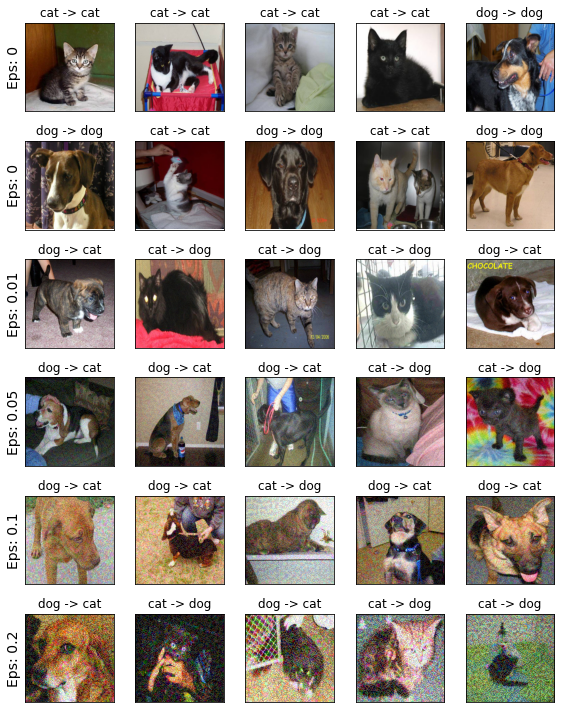

In [26]:
# Plot several examples of adversarial samples at each epsilon
def plot_adversarial_examples(epsilons, examples, class_names):
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(class_names[orig], class_names[adv]))
            inp = ex.transpose((1, 2, 0))
            plt.imshow(inp, cmap="gray")
    plt.tight_layout()
    plt.show()

plot_adversarial_examples(epsilons, examples, class_names)

# Classical Model

### Note that code is same as above, so refer to above comments for details

In [28]:
for param in resnet18.parameters():
    param.requires_grad = False
# Swap fc linear layer to use 2 class output
resnet18.fc = nn.Linear(in_features=512, out_features=2)
resnet18 = resnet18.to(device)

In [29]:
loss_func = nn.CrossEntropyLoss()
optimizer_classical = optim.Adam(resnet18.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_classical, step_size=10, gamma=gamma_lr_scheduler
)

In [30]:
resnet18 = train(resnet18, loss_func, optimizer_classical, exp_lr_scheduler, num_epochs=num_epochs)

Training started:


  0%|                                                                                   | 0/10 [00:00<?, ?it/s]

Phase: train Epoch: 1/10 Loss: 0.2020 Acc: 0.9314        


 10%|███████▌                                                                   | 1/10 [01:14<11:14, 74.91s/it]

Phase: validation   Epoch: 1/10 Loss: 0.1055 Acc: 0.9640        
Phase: train Epoch: 2/10 Loss: 0.0956 Acc: 0.9689        


 20%|███████████████                                                            | 2/10 [02:29<09:59, 74.97s/it]

Phase: validation   Epoch: 2/10 Loss: 0.0857 Acc: 0.9685        
Phase: train Epoch: 3/10 Loss: 0.0814 Acc: 0.9706        


 30%|██████████████████████▌                                                    | 3/10 [03:44<08:45, 75.02s/it]

Phase: validation   Epoch: 3/10 Loss: 0.0841 Acc: 0.9660        
Phase: train Epoch: 4/10 Loss: 0.0763 Acc: 0.9714        


 40%|██████████████████████████████                                             | 4/10 [04:59<07:29, 74.99s/it]

Phase: validation   Epoch: 4/10 Loss: 0.0704 Acc: 0.9750        
Phase: train Epoch: 5/10 Loss: 0.0697 Acc: 0.9735        


 50%|█████████████████████████████████████▌                                     | 5/10 [06:15<06:15, 75.11s/it]

Phase: validation   Epoch: 5/10 Loss: 0.0673 Acc: 0.9755        
Phase: train Epoch: 6/10 Loss: 0.0674 Acc: 0.9749        


 60%|█████████████████████████████████████████████                              | 6/10 [07:29<04:59, 74.98s/it]

Phase: validation   Epoch: 6/10 Loss: 0.0677 Acc: 0.9745        
Phase: train Epoch: 7/10 Loss: 0.0670 Acc: 0.9743        


 70%|████████████████████████████████████████████████████▌                      | 7/10 [08:45<03:45, 75.05s/it]

Phase: validation   Epoch: 7/10 Loss: 0.0657 Acc: 0.9760        
Phase: train Epoch: 8/10 Loss: 0.0646 Acc: 0.9751        


 80%|████████████████████████████████████████████████████████████               | 8/10 [10:00<02:30, 75.24s/it]

Phase: validation   Epoch: 8/10 Loss: 0.0636 Acc: 0.9795        
Phase: train Epoch: 9/10 Loss: 0.0622 Acc: 0.9752        


 90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [11:15<01:15, 75.13s/it]

Phase: validation   Epoch: 9/10 Loss: 0.0642 Acc: 0.9770        
Phase: train Epoch: 10/10 Loss: 0.0602 Acc: 0.9773        


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [12:30<00:00, 75.05s/it]

Phase: validation   Epoch: 10/10 Loss: 0.0632 Acc: 0.9790        
Best test loss: 0.0632 | Best test accuracy: 0.9795


In [31]:
epsilons = [0.0, 0.01, 0.05, 0.1, 0.2]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(resnet18, device, dataloaders['test'], eps)
    accuracies.append(acc)
    examples.append(ex)

100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.91it/s]


Epsilon: 0.0	Test Accuracy = 1950 / 2000 = 0.975


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.66it/s]


Epsilon: 0.01	Test Accuracy = 146 / 2000 = 0.073


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.15it/s]


Epsilon: 0.05	Test Accuracy = 436 / 2000 = 0.218


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.89it/s]


Epsilon: 0.1	Test Accuracy = 703 / 2000 = 0.3515


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.29it/s]

Epsilon: 0.2	Test Accuracy = 928 / 2000 = 0.464


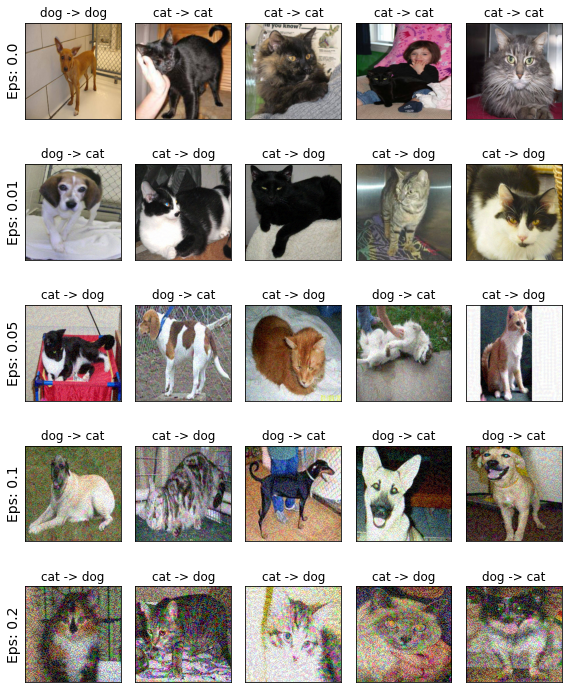

In [32]:
# Plot several examples of adversarial samples at each epsilon
plot_adversarial_examples(epsilons, examples, class_names)